In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
from scipy.stats import wilcoxon
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

from kneed import KneeLocator

from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample, shuffle

from ICOMP import *
# https://github.com/Pongpisit-Thanasutives/ICOMP
import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *
from mdl_comp import *

Sklearn's version: 1.4.0


#### Load data and add noise

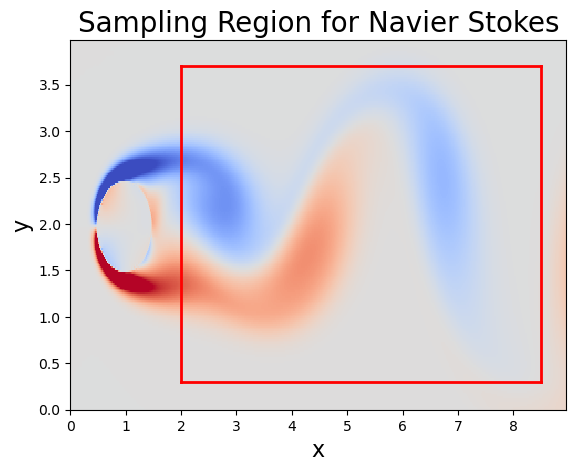

In [2]:
# Load data
steps = 151
n = 449
m = 199
# U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
# V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
# W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')
U = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

x = np.arange(n)*dx
y = np.arange(m)*dy
t = np.arange(steps)*dt

# plot the data
xx, yy = np.meshgrid(x, y)
plt.pcolor(xx,yy,W[:,:,75].T,cmap='coolwarm', vmin=-4, vmax=4, shading='auto')

# Cut out the portion of the data before the cylinder
xmin = 100*dx
xmax = 425*dx
ymin = 15*dy
ymax = 185*dy
plt.plot([xmin,xmin],[ymin,ymax],'r',linewidth = 2)
plt.plot([xmax,xmax],[ymin,ymax],'r',linewidth = 2)
plt.plot([xmin,xmax],[ymin,ymin],'r',linewidth = 2)
plt.plot([xmin,xmax],[ymax,ymax],'r',linewidth = 2)
plt.xlim([0,n*dx-dx])
plt.ylim([0,m*dy])
plt.title('Sampling Region for Navier Stokes', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)

xmin = 100
xmax = 425
ymin = 15
ymax = 185
x = x[xmin:xmax]
y = y[ymin:ymax]
W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

# Add in noise with magnitude equal to 1% of std dev of data
noise_lv = 1
np.random.seed(0)
W = W + noise_lv*0.01*np.std(W)*np.random.randn(n,m,steps)
U = U + noise_lv*0.01*np.std(U)*np.random.randn(n,m,steps)
V = V + noise_lv*0.01*np.std(V)*np.random.randn(n,m,steps)

#### Denoise

In [3]:
wn = W.T
un = U.T
vn = V.T

div = 30
ws = max(un[0].shape)//div; po = 2
if ws%2 == 0: ws -=1
    
wnd = []
for i in trange(wn.shape[0]):
    wnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(wn[i]))
W = np.stack(wnd, axis=0).T
    
und = []
for i in trange(un.shape[0]):
    und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
U = np.stack(und, axis=0).T

vnd = []
for i in trange(vn.shape[0]):
    vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
V = np.stack(vnd, axis=0).T

del und, vnd, un, vn

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:01<00:00, 104.12it/s]


In [4]:
Wn = W.reshape(n*m,steps)
Un = U.reshape(n*m,steps)
Vn = V.reshape(n*m,steps)
uwn,sigmawn,vwn = np.linalg.svd(Wn, full_matrices=False); vwn = vwn.T
uun,sigmaun,vun = np.linalg.svd(Un, full_matrices=False); vun = vun.T
uvn,sigmavn,vvn = np.linalg.svd(Vn, full_matrices=False); vvn = vvn.T
dim_w = 26
dim_u = 20
dim_v = 20
W = uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)).reshape(n,m,steps)
U = uun[:,0:dim_u].dot(np.diag(sigmaun[0:dim_u]).dot(vun[:,0:dim_u].T)).reshape(n,m,steps)
V = uvn[:,0:dim_v].dot(np.diag(sigmavn[0:dim_v]).dot(vvn[:,0:dim_v].T)).reshape(n,m,steps)
del Wn, Un, Vn

#### Applying best-subset regression on the candidate library

In [5]:
def build(*args): return np.stack([a.ravel() for a in args], axis=-1)

acc=4
d_dx = FinDiff(0, dx, 1, acc=acc)
d_dxx = FinDiff(0, dx, 2, acc=acc)
d_dy = FinDiff(1, dy, 1, acc=acc)
d_dyy = FinDiff(1, dy, 2, acc=acc)
d_dt = FinDiff(2, dt, 1, acc=acc)

W_x, W_y, W_xx, W_yy = d_dx(W), d_dy(W), d_dxx(W), d_dyy(W)

In [6]:
data_names = ['w', 'u', 'v']
diff_names = ['w_{x}', 'w_{y}', 'w_{xx}', 'w_{yy}']
inter_names = data_names + diff_names
inter = []
for i, data in enumerate([W, U, V]):
    for j, diff in enumerate([W_x, W_y, W_xx, W_yy]):
        inter.append(data*diff)
        inter_names.append(data_names[i]+diff_names[j])
inter_names

['w',
 'u',
 'v',
 'w_{x}',
 'w_{y}',
 'w_{xx}',
 'w_{yy}',
 'ww_{x}',
 'ww_{y}',
 'ww_{xx}',
 'ww_{yy}',
 'uw_{x}',
 'uw_{y}',
 'uw_{xx}',
 'uw_{yy}',
 'vw_{x}',
 'vw_{y}',
 'vw_{xx}',
 'vw_{yy}']

In [7]:
X_pre = build(W, U, V, d_dx(W), d_dy(W), d_dxx(W), d_dyy(W), *inter)
y_pre = d_dt(W).ravel().reshape(-1, 1)

In [8]:
best_subsets = solvel0(X_pre, y_pre, is_normal=False, max_complexity=1+X_pre.shape[-1]//2)
best_subsets

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00,  9.47s/it]


[(3,),
 (11, 16),
 (6, 11, 16),
 (5, 6, 11, 16),
 (0, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 13, 14, 16),
 (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

#### Model selection by the UBIC (Algorithm 1)

In [9]:
tau = 3
# scale = 1
scale = np.log(len(y_pre))
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), 
                                               u_type='cv1', take_sqrt=True, unbiased=True)
print(min(b_bics)-max(b_bics))

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*len(efi)
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
#     now_lam = last_lam-delta
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), imp)
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
    
last_lam, last_ubic, last_bc, best_bc

-28710947.291150436
0.12455816870398338
max_lam: 6.106720590157475
3 <---> 4 0.018764127536329556


(6.106720590157475,
 array([ 8.17101910e+07,  2.94538552e+07,  3.95072252e+06, -1.86264515e-08,
         8.77757465e+06,  4.00293137e+07,  4.17739770e+07,  7.15832156e+07,
         7.52686570e+07,  7.84919616e+07]),
 3,
 3)

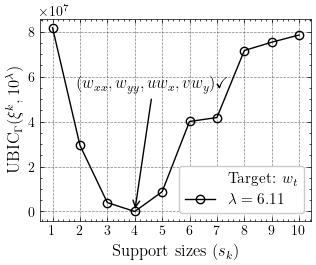

In [10]:
complexities = [len(efi) for efi in best_subsets]
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $w_t$')
    ax.plot(complexities, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(round(last_lam, 2))}$")
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(w_{xx}, w_{yy}, uw_{x}, vw_{y})\checkmark$', fontsize=12, 
                 xy=(complexities[best_bc], last_ubic[best_bc]), 
                 xytext=(complexities[best_bc]-2.125, last_ubic[1]+2.5e7), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=11)
    plt.show()

#### Percent coefficient error

In [11]:
ground_coeffs = np.array([0.01, 0.01, -1, -1])
est_coeffs = np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], y_pre, rcond=None)[0].flatten()
errs = 100*np.abs(est_coeffs-ground_coeffs)/np.abs(ground_coeffs)
errs.mean(), errs.std()

(11.42862052186804, 13.445956875677117)

In [12]:
print(KneeLocator(complexities, b_bics, S=1.0, curve='convex', direction='decreasing', 
            online=False).knee)

print(KneeLocator(complexities, b_bics, S=1.0, curve='convex', direction='decreasing', 
            online=False, interp_method="polynomial", polynomial_degree=3).knee)

print(KneeLocator(complexities, b_bics, S=1.0, curve='convex', direction='decreasing', 
            online=False, interp_method="polynomial", polynomial_degree=7).knee)

3
4
3


In [13]:
data = []
for i, c in enumerate(complexities):
    data.append([c, b_bics[i]])
data = np.array(data)
data

array([[ 1.00000000e+00,  7.47068647e+06],
       [ 2.00000000e+00, -8.71938645e+06],
       [ 3.00000000e+00, -1.81193497e+07],
       [ 4.00000000e+00, -2.03762627e+07],
       [ 5.00000000e+00, -2.07586055e+07],
       [ 6.00000000e+00, -2.09273769e+07],
       [ 7.00000000e+00, -2.10585745e+07],
       [ 8.00000000e+00, -2.11533923e+07],
       [ 9.00000000e+00, -2.12308825e+07],
       [ 1.00000000e+01, -2.12402608e+07]])

2


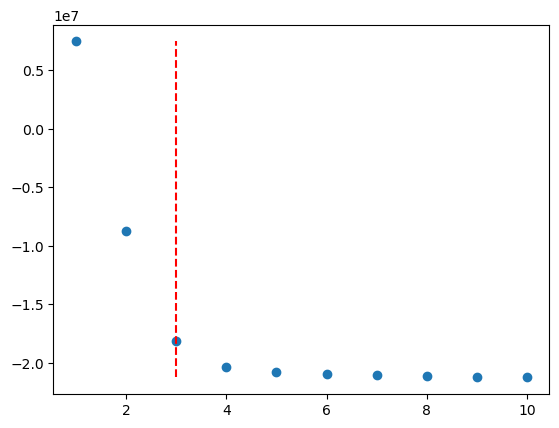

In [14]:
from kneebow.rotor import Rotor
rotor = Rotor()
rotor.fit_rotate(data)
elbow_idx = rotor.get_elbow_index()
print(elbow_idx)
rotor.plot_elbow()

In [15]:
# Informational complexity criteria for data-driven PDE discovery
# Input exog, y_pre, a_n,
tau = 9
a_n = np.log(len(y_pre)) # 1, ..., len(y_pre)
a_n = 0.01*len(y_pre)
a_n = np.linspace(0, len(y_pre)/np.log(len(y_pre)), tau)[1]
icomps = []
for idx in range(len(best_subsets)):
    exog = X_pre[:, best_subsets[idx]]
    m = sm.OLS(y_pre, exog)
    m_res = m.fit()
    q = m.rank; N = len(y_pre)
    rss = np.sum(m_res.resid**2)
    # S = exog.T@exog
    # S_inv = np.linalg.inv(S) # np.linalg.pinv(S, hermitian=True)
    S_inv = m_res.cov_params(scale=1) # (scale) * (X.T X)^(-1)

    C0 = np.trace(np.log(S_inv))-np.log(np.linalg.det(S_inv))
    C1 = q*np.log(np.trace(S_inv)/q)-np.log(np.linalg.det(S_inv))
    C_IFIM = (q+1)*np.log((np.trace(S_inv) + 2*rss/N)/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss/N)
    C_COV = (q+1)*np.log((np.trace(S_inv) + 2*rss*(N-q)/(N**2))/(q+1)) - \
                np.log(np.linalg.det(S_inv)) - np.log(2*rss*(N-q)/(N**2))

    C0 = C0/2
    C1 = C1/2
    C_IFIM = C_IFIM/2
    C_COV = C_COV/2

    llf = m_res.llf

    # 'CO', 'C1', 'IFIM', 'COV'
    icomp = [-2*llf + 2*a_n*C0, -2*llf + 2*a_n*C1, -2*llf + 2*a_n*C_IFIM, -2*llf + 2*a_n*C_COV]
    icomps.append(icomp)
    
icomps = np.array(icomps).T

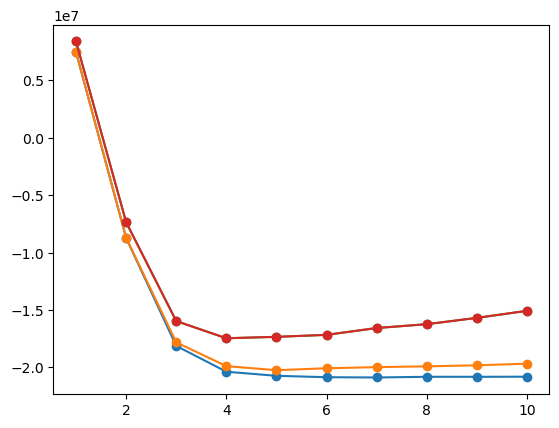

In [16]:
plt.plot(complexities, icomps[0], '-o')
plt.plot(complexities, icomps[1], '-o')
plt.plot(complexities, icomps[2], '-o')
plt.plot(complexities, icomps[3], '-o')
plt.show()

In [17]:
np.argmin(icomps[0]), np.argmin(icomps[1]), np.argmin(icomps[2]), np.argmin(icomps[3])

(6, 4, 3, 3)

In [18]:
theta, dt = shuffle(X_pre, y_pre, random_state=0)

In [19]:
n_resample = 30
n_samples = 1000
v_icomps = []
for bs in best_subsets:
    icomps = []
    beta = np.linalg.lstsq(X_pre[:, bs], y_pre, rcond=None)[0]
    for _ in range(n_resample):
        idx = sample_without_replacement(n_population=theta.shape[0]-1, n_samples=n_samples, random_state=_)
        X_resample, y_resample = theta[idx], dt[idx]
        X_resample = X_resample[:, bs]
        llf, CM, icomp = llf_complexity(X_resample, y_resample, beta=beta, a_n=np.log(len(y_resample)))
        icomp = icomp[2]
        icomps.append(icomp)
    v_icomps.append(icomps)
v_icomps = np.array(v_icomps)
v_icomps_ranking = np.argsort(v_icomps.sum(axis=-1))

for i in range(1, len(best_subsets)):
    wres = wilcoxon(v_icomps[i], v_icomps[i-1], alternative='less')
    print(wres.pvalue)

9.313225746154785e-10
9.313225746154785e-10
9.313225746154785e-10
3.4552067518234253e-07
0.3131731441244483
0.8553168969228864
0.8357650712132454
0.889676621183753
1.0


In [20]:
a_n = np.log(len(y_pre))
CMs = []; llfs = []
for bs in best_subsets: 
    beta = np.linalg.lstsq(X_pre[:, bs], y_pre, rcond=None)[0]
    llf, CM, _ = llf_complexity(X_pre[:, bs], y_pre, beta=beta, a_n=a_n)
    CM = CM[2]
    if np.equal(CM, np.inf): break
    CMs.append(CM)
    llfs.append(llf)
llfs = np.array(llfs); CMs = np.array(CMs)
last_icomps, last_bc = icomp_ic(llfs, CMs, a_n)
icomps = last_icomps.copy()
per = 75
d_complexities = np.array(complexities)[decreasing_values_indices(icomps)]
d_icomps = icomps[decreasing_values_indices(icomps)]
thres = np.percentile(np.abs(np.diff(d_icomps)/(np.diff(d_complexities)*d_icomps[:-1])), per)
print("Threshold", thres)
pthres = 1e-2
print("P-Threshold", pthres)

num_an = 5
a_ns = np.log(len(y_pre))**np.linspace(1, np.log((llfs/CMs).max()), num_an)
last_an = a_ns[0]
for a_n in a_ns[1:]:
    now_icomp, now_bc = icomp_ic(llfs, CMs, a_n)
    
    diff_com = now_bc-last_bc
    diff_icomp = icomps[now_bc]-icomps[last_bc]
    imp = abs(diff_icomp/(icomps[min(last_bc, now_bc)]*diff_com))
    diff_v_icomp = v_icomps[now_bc]-v_icomps[last_bc]
    pvalue_pos, pvalue_neg, pvalue_adj = np.nan, np.nan, np.nan
    adj_coms = v_icomps_ranking[v_icomps_ranking<now_bc]
    if not np.array_equal(diff_v_icomp, np.zeros(len(diff_v_icomp))):
        pvalue_pos = wilcoxon(diff_v_icomp, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_v_icomp, alternative='less').pvalue
        if len(adj_coms) != 0:
            pvalue_adj = wilcoxon(v_icomps[now_bc]-v_icomps[adj_coms[0]], alternative='less').pvalue

    print(last_bc, '--->', now_bc, 
          np.nan_to_num(imp, nan=np.inf), 
          np.nan_to_num(pvalue_pos, nan=np.inf), 
          np.nan_to_num(pvalue_neg, nan=np.inf))
    
    ### Old version ###
    # if (diff_com > 0 and (diff_icomp > 0 or imp <= thres)) or \
    #     (diff_com < 0 and diff_icomp > 0 and imp >= thres):
    #     break
    
    if (diff_com > 0 and (diff_icomp > 0 or pvalue_pos > pthres or pvalue_adj > pthres)) or \
        (diff_com < 0 and diff_icomp > 0 and pvalue_neg <= pthres):
        break
    
    last_an = a_n
    last_icomps = now_icomp
    last_bc = now_bc
    
last_an, last_icomps, last_bc

Threshold 0.12455211191727109
P-Threshold 0.01
9 ---> 3 0.007061561156815759 0.9540251865983009 0.04805078636854887
3 ---> 0 1.2424443428078442 1.0 9.313225746154785e-10


(74844.10275293184,
 array([  8517766.28224815,  -7148890.4220849 , -15646386.67790611,
        -17033025.76035746, -16838729.91856622, -16616087.02055094,
        -15917953.48595094, -15521728.73560248, -14881301.06548829,
        -14178532.40508696]),
 3)

9


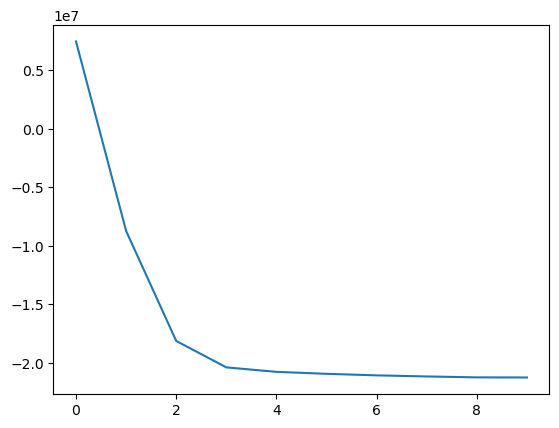

In [21]:
mdls = []
for bs in best_subsets:
    X_train = X_pre[:, bs]
    beta = np.linalg.lstsq(X_train, y_pre, rcond=None)[0]
    var = np.linalg.norm(y_pre-X_train@beta, ord=2)**2
    var = var/(len(y_pre)-len(bs))

    prac_mdl = prac_mdl_comp(X_train, y_pre, variance=var)
    mdl = prac_mdl['prac_mdl']
    thetahat = prac_mdl['thetahat']
    
    llf, CM, icomp = llf_complexity(X_train, y_pre, 
                                    beta=thetahat, 
                                    a_n=np.log(len(y_pre)))
    icomp = icomp[2]
    
    # mdls.append(mdl)
    mdls.append(icomp)

print(np.argmin(mdls))
plt.plot(mdls)